Group 1:
- Olga Pendleton (labeled data, built models)
- Amer Hot (labeled data, built models)
- Jason Paragallo (labeled data, built models)
- Justin Lucci (labeled data, built models)

# **'Ove' Gloves**

In [ ]:
# Importing reguired packages.
import pandas as pd
import nltk
import string
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import log_loss
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.decomposition import PCA
import plotly.express as px
import tensorflow as tf
from imblearn.metrics import geometric_mean_score
import numpy as np
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import f1_score
from numpy import arange
from sklearn.feature_selection import SelectKBest, chi2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Reading the dataset.
ove = pd.read_csv('Ove_label.csv')
ove.head()

,review_date,handle,rating,helpfulness_rating,Amer label,Olga label,Jason label,Justin label,Final label,review
0,24-Mar-23,Lynette51,5.0,NaN,0,0,0,NaN,0,Great product
1,23-Mar-23,J. Young,5.0,NaN,0,0,0,NaN,0,Replaced an older pair with the new ones after...
2,22-Mar-23,Denise Lynn Wells,5.0,NaN,0,0,0,NaN,0,The gloves have more flexibility than mitts or...
3,20-Mar-23,J J,5.0,NaN,0,0,0,NaN,0,I bought these to replace worn-out greasy glov...
4,18-Mar-23,Mrs. B,5.0,NaN,0,0,0,NaN,0,These are so great- they protect you from the ...


In [ ]:
ove.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851 entries, 0 to 850
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   review_date         851 non-null    object 
 1   handle              850 non-null    object 
 2   rating              836 non-null    float64
 3   helpfulness_rating  90 non-null     object 
 4   Amer label          851 non-null    int64  
 5   Olga label          851 non-null    int64  
 6   Jason label         851 non-null    int64  
 7   Justin label        0 non-null      float64
 8   Final label         851 non-null    int64  
 9   review              851 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 66.6+ KB


In [ ]:
ove.shape

(851, 10)

The dataset has 851 rows and 10 columns. Each row represents a review for a given product. 

In [ ]:
# Counting all values in "Final Label" column.
print(ove['Final label'].value_counts())

0    803
1     48
Name: Final label, dtype: int64


In [ ]:
# Calculating persantage of values in the 'Final label' column.
print(ove['Final label'].value_counts(normalize = True).mul(100).round(2))

0    94.36
1     5.64
Name: Final label, dtype: float64


The 'Final label' column has values 0, 1. They represent:
- Not counterfeit product as 0, 
- Counterfeit product as 1, 

The dataset has:
- Not counterfeit product reviews: 803 (94.36%)
- Counterfeit product reviews: 48 (5.64%)

In [ ]:
# Dropping columns that are not useful.
ove.drop(columns = ['review_date','handle','helpfulness_rating', 'Amer label', 'Olga label', 'Jason label', 'Justin label'], inplace = True)
ove.head()

,rating,Final label,review
0,5.0,0,Great product
1,5.0,0,Replaced an older pair with the new ones after...
2,5.0,0,The gloves have more flexibility than mitts or...
3,5.0,0,I bought these to replace worn-out greasy glov...
4,5.0,0,These are so great- they protect you from the ...


In [ ]:
# 1. Pre-process data as appropriate (10 pts.)
# Printing stopwords.
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
# Creating a function for preprocessing reviews.
def review_preprocess(t):
    # Converting all words to lower case.
    clean_r = t.lower()
    # Removing punctuations.
    clean_r = [char for char in clean_r if char not in string.punctuation]
    clean_r = ''.join(clean_r)
    # Removing numbers.
    clean_r = re.sub("\d", "", clean_r)
    # Removing stopwords.
    clean_r = [word for word in clean_r.split() if word not in stopwords.words('english')]
    clean_r = ' '.join(clean_r)
    return clean_r

In [ ]:
# Applying the function to the column in DataFrame.
ove['review'] = ove['review'].apply(review_preprocess)
ove.head()

,rating,Final label,review
0,5.0,0,great product
1,5.0,0,replaced older pair new ones many years didn’t...
2,5.0,0,gloves flexibility mitts flat potholders
3,5.0,0,bought replace wornout greasy gloves last cent...
4,5.0,0,great protect heat right oven doesnt seem like...


In [ ]:
# Vectorizing the corpus using TFIDF.
stemmer = SnowballStemmer("english")
def tokenize_and_stem(text):
    # First tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [ ]:
# Splitting dataset into training and testing.
X_o = ove['review']
y_o = ove['Final label']

X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_o, y_o, test_size = 0.33, random_state = 101)

In [ ]:
# 2. Build Naive Bayes and a sequential model with sentence embedding (300 dimensions) (10 pts.)
# 3. Assess model performance, pick one metric to compare model performance and explain your metric choice. (10 pts.)
# G-means.
# Listing the models that will be built.
names = ["Naive Bayes", "Logistic Regression", "Decision Tree", "Boosted Tree", "Random Forest", "SVM"]

# Defining the corresponding list of classifiers, setting parameters for each model.
classifiers = [MultinomialNB(),
               LogisticRegression(),
               DecisionTreeClassifier(max_depth = 5),
               AdaBoostClassifier(), 
               RandomForestClassifier(max_depth = 5, n_estimators = 10),
               SVC(probability = True), 
               ]

# Creating a dictionary to store the optimal thresholds for each model.
thresholds = {}

# Fitting each classifier to the training set, making predictions on the test set,
# evaluating performance, and finding the optimal threshold for each model.
for name, clf in zip(names, classifiers):
    clf_pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_df = 0.9, max_features = 5000,
                                  min_df = 0.1,
                                  use_idf = True, tokenizer = tokenize_and_stem, ngram_range = (1, 3))), 
        (name, clf)
    ])
  
    clf_pipe.fit(X_train_o, y_train_o)

    pred_prob = clf_pipe.predict_proba(X_test_o)[:, 1]
    fpr, tpr, thresholds_ = roc_curve(y_test_o, pred_prob)

    # Computing the G-mean for each threshold.
    g_mean = []
    for thresh in thresholds_:
        pred = (pred_prob >= thresh).astype(int)
        g_mean.append(geometric_mean_score(y_test_o, pred))

    # Choosing the threshold that maximizes the G-mean.
    optimal_idx = np.argmax(g_mean)
    optimal_threshold = thresholds_[optimal_idx]

    # Storing the optimal threshold in the dictionary.
    thresholds[name] = optimal_threshold

    # Making predictions using the optimal threshold.
    pred = (pred_prob >= optimal_threshold).astype(int)

    roc_auc = roc_auc_score(y_test_o, pred_prob)
    log_loss_val = log_loss(y_test_o, pred_prob)
    g_mean_val = geometric_mean_score(y_test_o, pred)

    target_names = ['Not counterfeit product', 'Counterfeit product']

    print('\n\n', name, '\n\n')
    print(classification_report(y_test_o, pred, target_names = target_names))
    print('ROC AUC: ', round(roc_auc, 2))
    print('Log loss: ', round(log_loss_val, 2))
    print('G-mean: ', round(g_mean_val, 2))
    print('Optimal threshold: ', round(optimal_threshold, 2))
    print('\n\n')

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(




 Naive Bayes 


                         precision    recall  f1-score   support

Not counterfeit product       0.99      0.81      0.89       262
    Counterfeit product       0.24      0.84      0.37        19

               accuracy                           0.81       281
              macro avg       0.61      0.82      0.63       281
           weighted avg       0.94      0.81      0.85       281

ROC AUC:  0.88
Log loss:  0.2
G-mean:  0.82
Optimal threshold:  0.06





/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(




 Logistic Regression 


                         precision    recall  f1-score   support

Not counterfeit product       0.98      0.85      0.91       262
    Counterfeit product       0.27      0.79      0.41        19

               accuracy                           0.84       281
              macro avg       0.63      0.82      0.66       281
           weighted avg       0.93      0.84      0.88       281

ROC AUC:  0.89
Log loss:  0.18
G-mean:  0.82
Optimal threshold:  0.08





/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(




 Decision Tree 


                         precision    recall  f1-score   support

Not counterfeit product       0.95      0.85      0.90       262
    Counterfeit product       0.17      0.42      0.24        19

               accuracy                           0.82       281
              macro avg       0.56      0.63      0.57       281
           weighted avg       0.90      0.82      0.85       281

ROC AUC:  0.58
Log loss:  1.48
G-mean:  0.6
Optimal threshold:  0.05





/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(




 Boosted Tree 


                         precision    recall  f1-score   support

Not counterfeit product       0.98      0.71      0.82       262
    Counterfeit product       0.16      0.79      0.27        19

               accuracy                           0.72       281
              macro avg       0.57      0.75      0.55       281
           weighted avg       0.92      0.72      0.79       281

ROC AUC:  0.8
Log loss:  0.44
G-mean:  0.75
Optimal threshold:  0.4





/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(




 Random Forest 


                         precision    recall  f1-score   support

Not counterfeit product       0.97      0.85      0.91       262
    Counterfeit product       0.25      0.68      0.36        19

               accuracy                           0.84       281
              macro avg       0.61      0.77      0.63       281
           weighted avg       0.92      0.84      0.87       281

ROC AUC:  0.85
Log loss:  0.19
G-mean:  0.76
Optimal threshold:  0.09





/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(




 SVM 


                         precision    recall  f1-score   support

Not counterfeit product       0.99      0.64      0.77       262
    Counterfeit product       0.15      0.89      0.26        19

               accuracy                           0.65       281
              macro avg       0.57      0.77      0.52       281
           weighted avg       0.93      0.65      0.74       281

ROC AUC:  0.82
Log loss:  0.21
G-mean:  0.76
Optimal threshold:  0.04





In [ ]:
# 2. Build Naive Bayes and a sequential model with sentence embedding (300 dimensions) (10 pts.)
# 3. Assess model performance, pick one metric to compare model performance and explain your metric choice. (10 pts.)
# Youden's J statistic
# Listing the models that will be built.
# names = ["Naive Bayes", "Logistic Regression", "Decision Tree", "Boosted Tree", "Random Forest", "SVM"]

# Define the corresponding list of classifiers, setting parameters where needed
# classifiers = [MultinomialNB(),
               # LogisticRegression(),
               # DecisionTreeClassifier(max_depth = 5),
               # AdaBoostClassifier(), 
               # RandomForestClassifier(max_depth = 5, n_estimators = 10),
               # SVC(probability = True), 
               # ]

# Define a dictionary to store the optimal thresholds for each model
# thresholds = {}

# Fit each classifier to the training set, make predictions on the test set,
# evaluate performance, and find the optimal threshold for each model
# for name, clf in zip(names, classifiers):
    # clf_pipe = Pipeline([
        # ('tfidf', TfidfVectorizer(max_df = 0.9, max_features = 5000,
                                  # min_df = 0.1,
                                  # use_idf = True, tokenizer = tokenize_and_stem, ngram_range = (1, 3))), 
        # (name, clf)
    # ])
  
    # clf_pipe.fit(X_train_o, y_train_o)

    # pred_prob = clf_pipe.predict_proba(X_test_o)[:, 1]
    # fpr, tpr, thresholds_ = roc_curve(y_test_o, pred_prob)

    # Compute the Youden's J statistic for each threshold
    # J = tpr - fpr
    # optimal_idx = np.argmax(J)
    # optimal_threshold = thresholds_[optimal_idx]

    # Store the optimal threshold in the dictionary
    # thresholds[name] = optimal_threshold

    # Make predictions using the optimal threshold
    # pred = (pred_prob >= optimal_threshold).astype(int)

    # roc_auc = roc_auc_score(y_test_o, pred_prob)
    # log_loss_val = log_loss(y_test_o, pred_prob)

    # target_names = ['Not counterfeit product', 'Counterfeit product']

    # print('\n\n', name, '\n\n')
    # print(classification_report(y_test_o, pred, target_names = target_names))
    # print('ROC AUC: ', round(roc_auc, 2))
    # print('Log loss: ', round(log_loss_val, 2))
    # print('Optimal threshold: ', round(optimal_threshold, 2))
    # print('\n\n')

In [ ]:
# Builsequential model with sentence embedding (300 dimensions).
# Pre-processing reviews for modeling.
vocab_size = 5000
embedding_dim = 300
max_length = 500
trunc_type ='post'
oov_tok = "<OOV>"

# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(X_train_o)

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train_o)
testing_sequences = tokenizer.texts_to_sequences(X_test_o)

# Padding
padded = pad_sequences(sequences, maxlen = max_length, truncating = trunc_type) 
testing_padded = pad_sequences(testing_sequences, maxlen = max_length)  

In [ ]:
# Developing a 2-layer (100, 100) fully-connected neural network model using review length 500 and 300-dimension.
# Using activation ='sigmoid', loss ='binary_crossentropy'
model_500_300_o = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation ='relu'),
    tf.keras.layers.Dense(100, activation ='relu'),
    tf.keras.layers.Dense(1, activation ='sigmoid')
])
model_500_300_o.compile(loss ='binary_crossentropy', optimizer ='adam', metrics = [tf.keras.metrics.AUC(name = 'roc_auc')])
model_500_300_o.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          1500000   
                                                                 
 flatten (Flatten)           (None, 150000)            0         
                                                                 
 dense (Dense)               (None, 100)               15000100  
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 16,510,301
Trainable params: 16,510,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training the model.
num_epochs = 100
history = model_500_300_o.fit(padded, y_train_o, epochs = num_epochs, validation_data = (testing_padded, y_test_o))

Epoch 1/100
18/18 [==============================] - 4s 157ms/step - loss: 0.2847 - roc_auc: 0.5533 - val_loss: 0.2475 - val_roc_auc: 0.8712
Epoch 2/100
18/18 [==============================] - 2s 137ms/step - loss: 0.1853 - roc_auc: 0.7075 - val_loss: 0.2147 - val_roc_auc: 0.9024
Epoch 3/100
18/18 [==============================] - 3s 166ms/step - loss: 0.1267 - roc_auc: 0.8737 - val_loss: 0.1305 - val_roc_auc: 0.9471
Epoch 4/100
18/18 [==============================] - 3s 150ms/step - loss: 0.0440 - roc_auc: 0.9838 - val_loss: 0.0938 - val_roc_auc: 0.9633
Epoch 5/100
18/18 [==============================] - 2s 139ms/step - loss: 0.0191 - roc_auc: 0.9786 - val_loss: 0.0838 - val_roc_auc: 0.9744
Epoch 6/100
18/18 [==============================] - 3s 144ms/step - loss: 0.0109 - roc_auc: 0.9992 - val_loss: 0.0979 - val_roc_auc: 0.9600
Epoch 7/100
18/18 [==============================] - 3s 162ms/step - loss: 0.0063 - roc_auc: 1.0000 - val_loss: 0.1050 - val_roc_auc: 0.9632
Epoch 8/100
1

In [ ]:
# Finding optimal threshold and evaluating the model.
y_pred_proba_o = model_500_300_o.predict(testing_padded)
y_pred_proba_o = y_pred_proba_o[:, 0]

fpr, tpr, thresholds = roc_curve(y_test_o, y_pred_proba_o)
sort_idx = np.argsort(thresholds)
fpr = fpr[sort_idx]
tpr = tpr[sort_idx]
thresholds = thresholds[sort_idx]

gmeans_ker = np.sqrt(tpr * (1-fpr))
gmeans_ker[np.isnan(gmeans_ker)] = 0

optimal_idx = np.argmax(gmeans_ker)
optimal_threshold = thresholds[optimal_idx]

y_pred = (y_pred_proba_o >= optimal_threshold).astype(int)

log_loss_val = log_loss(y_test_o, y_pred_proba_o)

print(classification_report(y_test_o, y_pred, target_names = target_names))
print('ROC AUC: ', round(auc(fpr, tpr), 2))
print("Optimal Threshold:", round(optimal_threshold, 20))
print('Log loss: ', round(log_loss_val, 2))

9/9 [==============================] - 0s 20ms/step
                         precision    recall  f1-score   support

Not counterfeit product       1.00      0.92      0.95       262
    Counterfeit product       0.45      0.95      0.61        19

               accuracy                           0.92       281
              macro avg       0.72      0.93      0.78       281
           weighted avg       0.96      0.92      0.93       281

ROC AUC:  0.97
Optimal Threshold: 0.00010273724
Log loss:  0.22


In [ ]:
# Evaluating the Neural Network model performance.
# y_pred_o = model_500_300_o.predict(testing_padded)
# y_pred_o = (y_pred_o >= 0.5)

# fpr, tpr, thresholds = roc_curve(y_test_o, y_pred_o)
# log_loss_val = log_loss(y_test_o, y_pred_o)

# print(classification_report(y_test_o, y_pred_o, target_names = target_names))
# print('ROC AUC: ', round(auc(fpr, tpr), 2))
# print('Log loss: ', round(log_loss_val, 2))

Accuracy, Precision, Recall, and F-measure are threshold-dependent metrics. ROC curve and AUC are threshold-independent. Youden's J statistic and G-means were used to find an optimal threshold. 
- ROC AUC:
     - Naive Bayes: 0.88
     - Logistic Regression: 0.89
     - Decision Tree: 0.58
     - Boosted Tree: 0.80
     - Random Forest: 0.83
     - SVM: 0.82
     - Keras: 0.97

Keras model has the best performance based on ROC AUC metric of 0.97 and optimal threshold of 0.00010273724.

Logistic Regression has the second best performance based on ROC AUC metric of 0.89 and optimal threshold of 0.08.

Becase the Keras optimal threshold is very small (almost equal to zero), the feaure importance for the non-counterfeit (0) product and counterfeit product (1) are the same.

We will use Naive Bayes model with ROC AUC of 0.88, optimal threshold of 0.06 for feature extraction. 


**Naive Bayes feature importance.**

In [ ]:
# Version 1. No optimal threshold.
# Rebuilding the Naive Bayes model.
vectorizer = TfidfVectorizer(ngram_range = (2, 3))
X_train_tfidf = vectorizer.fit_transform(X_train_o)

selector = SelectKBest(chi2, k = 'all')
selector.fit(X_train_tfidf, y_train_o)

X_train_selected = selector.transform(X_train_tfidf)

nb = MultinomialNB()
nb.fit(X_train_selected, y_train_o)

feature_names = vectorizer.get_feature_names_out()
selected_mask = selector.get_support()
selected_features = [feature_names[i] for i in range(len(feature_names)) if selected_mask[i]]

top_negative = np.argsort(nb.feature_log_prob_[1])[::-1][:10]
top_positive = np.argsort(nb.feature_log_prob_[0])[::-1][:10]

print("Top non-counterfeit features:", [selected_features[i] for i in top_positive])
print("Top counterfeit features:", [selected_features[i] for i in top_negative])

Top non-counterfeit features: ['works great', 'great product', 'ove glove', 'ove gloves', 'oven mitt', 'works well', 'good product', 'hot items', 'love ove', 'great price']
Top counterfeit features: ['real ove', 'ove glove', 'real ove glove', 'loop hang', 'ove gloves', 'real ove gloves', 'missing loop', 'missing loop hang', 'real deal', 'came china']


Top counterfeit features:
- 'ove glove', 'real ove glove', 'real ove': 

These features apperar in 26 reviws.

     - We own other ove gloves and the one we received is definitely a fake.  The box is full of spelling errors that tipped me off that this wasn't the real deal..  The glove doesn't have the same shape/elasticity as the real one we have.  I should have read the reviews but was misled since it said Amazon's Choice on the listing.  Real ove gloves are fantastic, wasn't going to take chances with this fake one.
     - Fake product.  They're too small and they don't have the hanging loops.  Real Ove Gloves are great--  this is nothing.  Avoid.

- 'loop hang', 'missing loop', 'missing loop hang'

These features apperar in 5 reviws.

     - missing loop to hang it up.
     - I love the real Ove Glove. What I received, however, was different from the one I had purchased several years ago. I believe it could have been counterfeit. Either that, or they have changed how they make them. There was no sewn in loop for hanging the glove up. Instead of a cloth tag with all of the info, there was only a small plastic (thermal BPA paper) tag. The amount of Kevalar to the other material changed. And it had an extremely strong chemical odor. Additionally, the silicone grip lines and letters were brighter and larger. I've returned it and now am hesitant of where I will order a replacement from. The first Ove Glove we had worked well for years until my husband washed and dried it. They can be machine washed, but they cannot do in a clothes dryer. Heat now goes through it much more quickly.

- 'real deal':

This feature apperars in 6 reviws.

      - We own other ove gloves and the one we received is definitely a fake.  The box is full of spelling errors that tipped me off that this wasn't the real deal..  The glove doesn't have the same shape/elasticity as the real one we have.  I should have read the reviews but was misled since it said Amazon's Choice on the listing.  Real ove gloves are fantastic, wasn't going to take chances with this fake one.
      - This was another fake as many others have posted.  Packaging looks great until you get inside and see the tell tale black seam on cuff, slightly different blue color and lack of tags.  It works OK as general potholder but I wouldn't test it to the limits listed on the packaging as I have no idea what it is really made of.  Price is inexpensive so that should be your clue.  I am disappointed that Amazon continues to use vendors that send out fake merchandise without making that amply clear in their description.  I tried very hard to get the real thing by reading all the reviews and picking the company that I believed would be sending out the real deal.  However I found that it was not shipped by the company I'd ordered from.

- 'came china':

This feature apperars in 9 reviws.

     - came from china in clearly after market packaging. It smells of chemicals.  I ordered two gloves and it came stuffed in a one glove box.  The "Ove Glove" tag is not sewn into the glove like the others I own.  It is clearly a knock off!  Buyer beware of where you are buying from!
     - I ordered two of these.  They came from China in plastic bags, not boxes as pictured.  I have small hands and they barely fit me.  And I can feel the heat right through them.  These gloves are no better than my old worn-out original Ove Gloves.  I am returning them.
     - Do not order from Happyshopping2013.  It is a counterfeit item.  It came from China, without the original packaging and has no tag with the manufacturing and care instructions on the inside.  I have a real "Ove" glove and this is not it!

- 'fake one':

This feature apperars in 2 reviws.

     - We own other ove gloves and the one we received is definitely a fake.  The box is full of spelling errors that tipped me off that this wasn't the real deal..  The glove doesn't have the same shape/elasticity as the real one we have.  I should have read the reviews but was misled since it said Amazon's Choice on the listing.  Real ove gloves are fantastic, wasn't going to take chances with this fake one.
     - Yes, you get two FAKE Ove Gloves sent to me by GF Sports. They are not as pictured but are the fake ones with the black stitching at the cuffs, no label, and no registration card. I thought Amazon had taken care of this but it looks like they have not done so.

- 'glove like':

This feature apperars in 3 reviws.

     - came from china in clearly after market packaging. It smells of chemicals.  I ordered two gloves and it came stuffed in a one glove box.  The "Ove Glove" tag is not sewn into the glove like the others I own.  It is clearly a knock off!  Buyer beware of where you are buying from!
     - I read the other reviews and it was confusing but THIS IS NOT THE OFFICIAL OVE GLOVE! I bought my first Ove Glove at Walgreen's and loved it so much I needed another. I went the cheap route and bought this one from JOSEPH ENTERPRISES. It has the the Ove Glove box but that's where the similarities end. The glove is tighter, a different blue, and it comes with a black band around the wrist (not pictured in their misleading add). It also has no tag inside the glove like the original one. Most importantly of all: It doesn't protect from heat like the original Ove Glove. Please heed my warning: DO NOT BUY THIS PRODUCT FROM THIS SELLER!


In [ ]:
# Version 2. With optimal treshold.
thresholds = {}

# Rebuilding Naive Bayes model.
names = 'Naive Bayes'
nb = MultinomialNB()

nb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(max_df = 0.9, max_features = 5000,
                              min_df = 0.1,
                              use_idf = True, tokenizer = tokenize_and_stem, ngram_range = (1, 3))), 
    ('nb', nb)
])

nb_pipe.fit(X_train_o, y_train_o)

pred_prob = nb_pipe.predict_proba(X_test_o)[:, 1]

# Computing the G-mean for each threshold.
g_mean = []
for thresh in thresholds_:
    pred = (pred_prob >= thresh).astype(int)
    g_mean.append(geometric_mean_score(y_test_o, pred))

# Choosing the threshold that maximizes the G-mean.
optimal_idx = np.argmax(g_mean)
optimal_threshold = thresholds_[optimal_idx]

# Storing the optimal threshold in the dictionary.
thresholds[name] = optimal_threshold

# Making predictions using the optimal threshold.
pred = (pred_prob >= optimal_threshold).astype(int)

# Get the feature probabilities from the classifier
feature_probs = nb.feature_log_prob_

# Get the feature names from the TfidfVectorizer
feature_names = nb_pipe.named_steps['tfidf'].get_feature_names_out()

# Sort the feature probabilities for class 0 (non-counterfeit)
sorted_probs_0 = np.argsort(feature_probs[0])[::-1]
top_features_0 = [feature_names[i] for i in sorted_probs_0[:10]]

# Sort the feature probabilities for class 1 (counterfeit)
sorted_probs_1 = np.argsort(feature_probs[1])[::-1]
top_features_1 = [feature_names[i] for i in sorted_probs_1[:10]]

print('Top features for non-counterfeit (class 0):', top_features_0)
print('Top features for counterfeit (class 1):', top_features_1)

Top features for non-counterfeit (class 0): ['great', 'glove', 'use', 'work', 'one', 'oven', 'love', 'hot', 'product', 'hand']
Top features for counterfeit (class 1): ['glove', 'ove glove', 'ove', 'one', 'get', 'use', 'heat', 'like', 'hand', 'product']


The features for counterfeit and non-counterfeit products are almost identical, which does not make any sence.

In [ ]:
# Accessing the Naive Bayes model and TfidfVectorizer from the pipeline.
nb_model = nb_pipe.named_steps['nb']
tfidf_vectorizer = nb_pipe.named_steps['tfidf']

# Accessing the feature log probabilities from the Naive Bayes model.
feature_log_prob = nb_model.feature_log_prob_

# Getting the feature names from the TfidfVectorizer.
feature_names = tfidf_vectorizer.get_feature_names_out()

# Creating a DataFrame to store the feature names and their associated log probabilities for each class.
df = pd.DataFrame({'feature_names': feature_names,
                   'non_counterfeit_log_prob': feature_log_prob[0],
                   'counterfeit_log_prob': feature_log_prob[1]})

# Sorting the DataFrame by the log probabilities for the counterfeit class.
df = df.sort_values('counterfeit_log_prob', ascending = False)

# Getting the top 10 most informative features associated with counterfeit products (class 1).
top_10_counterfeit = df.head(10)

# Getting the top 10 most informative features associated with non-counterfeit products (class 0).
top_10_non_counterfeit = df.tail(10)

In [ ]:
top_10_counterfeit

,feature_names,non_counterfeit_log_prob,counterfeit_log_prob
4,glove,-2.450333,-1.843055
13,ove glove,-3.286165,-2.159462
12,ove,-3.280057,-2.162770
11,one,-2.658475,-2.664495
2,get,-3.353822,-2.875218
16,use,-2.587296,-2.895698
7,heat,-3.376047,-2.938541
9,like,-3.357387,-3.020224
6,hand,-2.995086,-3.023802
15,product,-2.963883,-3.032287


In [ ]:
top_10_non_counterfeit

,feature_names,non_counterfeit_log_prob,counterfeit_log_prob
15,product,-2.963883,-3.032287
1,burn,-3.432977,-3.317646
17,work,-2.633680,-3.464858
18,year,-3.349060,-3.490568
0,bought,-3.275060,-3.579105
8,hot,-2.898027,-3.636424
3,gift,-3.251307,-3.833951
10,love,-2.773553,-3.910132
14,oven,-2.697897,-3.954298
5,great,-2.440169,-3.998649


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 23.0 MB/s eta 0:00:00


**Keras feature importance.**

In [ ]:
import shap
# Creating an explainer object for the best model (Keras).
explainer = shap.Explainer(model_500_300_o, testing_padded)

# Generating SHAP values for the testing dataset.
shap_values = explainer(testing_padded)

Permutation explainer: 282it [30:34,  6.57s/it]


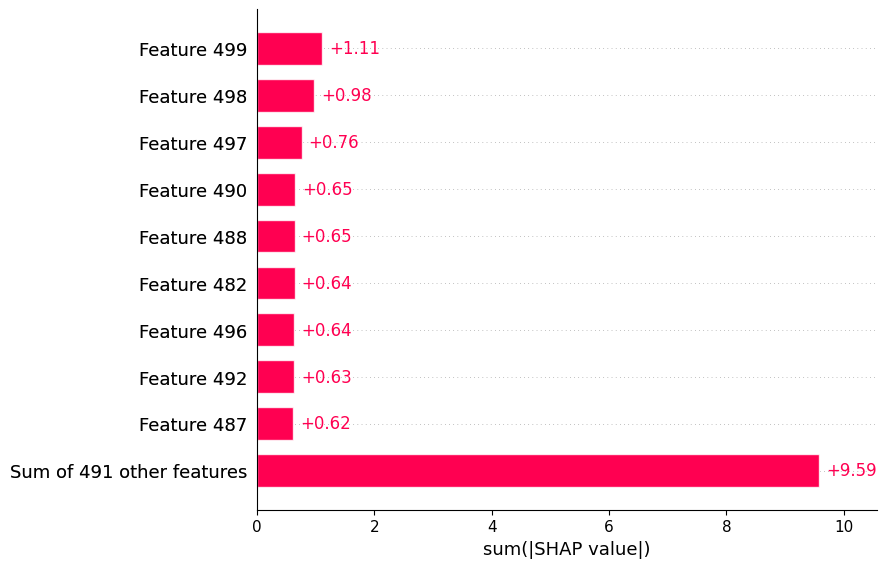

In [ ]:
shap.plots.bar(shap_values.abs.sum(0))

In [ ]:
# Extracting the mean absolute SHAP values for each feature
feature_importance = np.mean(np.abs(shap_values.values), axis=0)

# Getting the names of the features (words)
feature_names = [word for word, index in word_index.items() if index < vocab_size]

feature_df = pd.DataFrame(list(zip(feature_names, feature_importance)), columns=['feature', 'importance'])
feature_df = feature_df.sort_values('importance', ascending=False)
print(feature_df.head(20))

      feature  importance
499     stand    0.003956
498   opinion    0.003471
497      name    0.002708
490     brand    0.002315
488      save    0.002298
482     bring    0.002277
496   package    0.002261
492      live    0.002247
487  standard    0.002201
494      kind    0.002097
493     learn    0.001938
491      i’ve    0.001908
484     we’ve    0.001899
485       add    0.001774
495  compared    0.001745
486       air    0.001642
483  official    0.001487
489   generic    0.001441
481        nd    0.001329
479   grabbed    0.001027


In [ ]:
# Separating features by class: 0 and 1.
# Average the SHAP values for each feature over all the reviews in each class.
shap_values_0 = shap_values[y_test_o.values == 0].mean(axis=0)
shap_values_1 = shap_values[y_test_o.values == 1].mean(axis=0)

In [ ]:
# Getting the feature names.
feature_names = list(tokenizer.word_index.keys())

In [ ]:
# Convert the Explanation objects to numpy arrays
shap_values_0_np = shap_values_0.values
shap_values_1_np = shap_values_1.values

# Sorting the features based on their average importance values.
sorted_features_0 = [feature_names[i] for i in np.argsort(np.abs(shap_values_0_np))[::-1]]
sorted_features_1 = [feature_names[i] for i in np.argsort(np.abs(shap_values_1_np))[::-1]]

In [ ]:
# Printing the top 20 features for each class.
print("Top 20 features for non-counterfeit product (0):")
for feature in sorted_features_0[:20]:
    print(feature)
print()

print("Top 20 features for counterfeit product (1):")
for feature in sorted_features_1[:20]:
    print(feature)
print()

Top 20 features for non-counterfeit product (0):
stand
opinion
bring
brand
standard
i’ve
add
save
we’ve
package
learn
air
live
grabbed
generic
nd
thicker
straight
cool
messing

Top 20 features for counterfeit product (1):
opinion
stand
live
name
save
package
official
kind
brand
bring
compared
we’ve
standard
air
learn
add
i’ve
generic
nd
grabbed



# **UGG Boots**

In [ ]:
# Reading the dataset.
ugg = pd.read_csv('UGG_label.csv')
ugg.head()

,review_date,handle,rating,helpfulness_rating,Olga label,Amer label,Jason label,Justin label,Final label,review
0,6-Mar-23,Bereniz Flores,5.0,NaN,0,0,0,NaN,0,I love my boots especially since I was able to...
1,23-Feb-23,JESSICA Zerlotta,5.0,2,0,0,0,NaN,0,Southern California girl here…. I want to use ...
2,2-Mar-23,whiplash,5.0,One,0,0,0,NaN,0,Wife is 5’7 and has a muscular calf and likes ...
3,2-Mar-23,Gia,5.0,NaN,0,0,0,NaN,0,These are good quality. The texture is really ...
4,27-Feb-23,Rollin Olson,5.0,NaN,0,0,0,NaN,0,My wife is enjoying these


In [ ]:
ugg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101 entries, 0 to 1100
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   review_date         1101 non-null   object 
 1   handle              1101 non-null   object 
 2   rating              1003 non-null   float64
 3   helpfulness_rating  204 non-null    object 
 4   Olga label          1101 non-null   int64  
 5   Amer label          1101 non-null   int64  
 6   Jason label         1101 non-null   int64  
 7   Justin label        0 non-null      float64
 8   Final label         1101 non-null   int64  
 9   review              1101 non-null   object 
dtypes: float64(2), int64(4), object(4)
memory usage: 86.1+ KB


In [ ]:
ugg.shape

(1101, 10)

The dataset has 1101 rows and 10 columns. Each row represents a review for a given product. 

In [ ]:
# Counting all values in "Final Label" column.
print(ugg['Final label'].value_counts())

0    1038
1      63
Name: Final label, dtype: int64


In [ ]:
# Calculating persantage of values in the 'Final label' column.
print(ugg['Final label'].value_counts(normalize=True).mul(100).round(2))

0    94.28
1     5.72
Name: Final label, dtype: float64


The 'Final label' column has values 0, 1. They represent:
- Not counterfeit product as 0,
- Counterfeit product as 1,

The dataset has:
- Not counterfeit product reviews: 1038 (94.28%)
- Counterfeit product reviews: 63 (5.72%)



In [ ]:
# Dropping columns that are not useful.
ugg.drop(columns = ['review_date','handle','helpfulness_rating', 'Amer label', 'Olga label', 'Jason label', 'Justin label'], inplace = True)
ugg.head()

,rating,Final label,review
0,5.0,0,I love my boots especially since I was able to...
1,5.0,0,Southern California girl here…. I want to use ...
2,5.0,0,Wife is 5’7 and has a muscular calf and likes ...
3,5.0,0,These are good quality. The texture is really ...
4,5.0,0,My wife is enjoying these


In [ ]:
# 1. Pre-process data as appropriate (10 pts.)
# Applying the function to the column in DataFrame.
ugg['review'] = ugg['review'].apply(review_preprocess)
ugg.head()

,rating,Final label,review
0,5.0,0,love boots especially since able affirm make p...
1,5.0,0,southern california girl here… want use boots ...
2,5.0,0,wife ’ muscular calf likes tight fit style wid...
3,5.0,0,good quality texture really soft
4,5.0,0,wife enjoying


In [ ]:
# Splitting dataset into training and testing.
X_u = ugg['review']
y_u = ugg['Final label']

X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_u, y_u, test_size = 0.33, random_state = 101)

In [ ]:
# 2. Build Naive Bayes and a sequential model with sentence embedding (300 dimensions) (10 pts.)
# 3. Assess model performance, pick one metric to compare model performance and explain your metric choice. (10 pts.)
# G-means.
# Listing the models that will be built.
names = ["Naive Bayes", "Logistic Regression", "Decision Tree", "Boosted Tree", "Random Forest", "SVM"]

# Defining the corresponding list of classifiers, setting parameters for each model.
classifiers = [MultinomialNB(),
               LogisticRegression(),
               DecisionTreeClassifier(max_depth = 5),
               AdaBoostClassifier(), 
               RandomForestClassifier(max_depth = 5, n_estimators = 10),
               SVC(probability = True), 
               ]

# Creating a dictionary to store the optimal thresholds for each model.
thresholds = {}

# Fitting each classifier to the training set, making predictions on the test set,
# evaluating performance, and finding the optimal threshold for each model.
for name, clf in zip(names, classifiers):
    clf_pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_df = 0.9, max_features = 5000,
                                  min_df = 0.1,
                                  use_idf = True, tokenizer = tokenize_and_stem, ngram_range = (1, 3))), 
        (name, clf)
    ])
  
    clf_pipe.fit(X_train_u, y_train_u)

    pred_prob = clf_pipe.predict_proba(X_test_u)[:, 1]
    fpr, tpr, thresholds_ = roc_curve(y_test_u, pred_prob)

    # Computing the G-mean for each threshold.
    g_mean = []
    for thresh in thresholds_:
        pred = (pred_prob >= thresh).astype(int)
        g_mean.append(geometric_mean_score(y_test_u, pred))

    # Choosing the threshold that maximizes the G-mean.
    optimal_idx = np.argmax(g_mean)
    optimal_threshold = thresholds_[optimal_idx]

    # Storing the optimal threshold in the dictionary.
    thresholds[name] = optimal_threshold

    # Making predictions using the optimal threshold.
    pred = (pred_prob >= optimal_threshold).astype(int)

    roc_auc = roc_auc_score(y_test_u, pred_prob)
    log_loss_val = log_loss(y_test_u, pred_prob)
    g_mean_val = geometric_mean_score(y_test_u, pred)

    target_names = ['Not counterfeit product', 'Counterfeit product']

    print('\n\n', name, '\n\n')
    print(classification_report(y_test_u, pred, target_names = target_names))
    print('ROC AUC: ', round(roc_auc, 2))
    print('Log loss: ', round(log_loss_val, 2))
    print('G-mean: ', round(g_mean_val, 2))
    print('Optimal threshold: ', round(optimal_threshold, 2))
    print('\n\n')

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(




 Naive Bayes 


                         precision    recall  f1-score   support

Not counterfeit product       1.00      0.65      0.78       345
    Counterfeit product       0.13      0.95      0.23        19

               accuracy                           0.66       364
              macro avg       0.56      0.80      0.51       364
           weighted avg       0.95      0.66      0.75       364

ROC AUC:  0.86
Log loss:  0.16
G-mean:  0.78
Optimal threshold:  0.06





/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(




 Logistic Regression 


                         precision    recall  f1-score   support

Not counterfeit product       0.98      0.82      0.89       345
    Counterfeit product       0.18      0.74      0.29        19

               accuracy                           0.82       364
              macro avg       0.58      0.78      0.59       364
           weighted avg       0.94      0.82      0.86       364

ROC AUC:  0.87
Log loss:  0.16
G-mean:  0.78
Optimal threshold:  0.07





/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(




 Decision Tree 


                         precision    recall  f1-score   support

Not counterfeit product       0.98      0.90      0.94       345
    Counterfeit product       0.26      0.63      0.37        19

               accuracy                           0.89       364
              macro avg       0.62      0.77      0.65       364
           weighted avg       0.94      0.89      0.91       364

ROC AUC:  0.76
Log loss:  0.45
G-mean:  0.75
Optimal threshold:  0.2





/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(




 Boosted Tree 


                         precision    recall  f1-score   support

Not counterfeit product       0.99      0.77      0.86       345
    Counterfeit product       0.17      0.84      0.28        19

               accuracy                           0.77       364
              macro avg       0.58      0.81      0.57       364
           weighted avg       0.95      0.77      0.83       364

ROC AUC:  0.84
Log loss:  0.52
G-mean:  0.8
Optimal threshold:  0.49





/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(




 Random Forest 


                         precision    recall  f1-score   support

Not counterfeit product       0.98      0.84      0.91       345
    Counterfeit product       0.19      0.68      0.30        19

               accuracy                           0.84       364
              macro avg       0.59      0.76      0.60       364
           weighted avg       0.94      0.84      0.88       364

ROC AUC:  0.85
Log loss:  0.16
G-mean:  0.76
Optimal threshold:  0.07





/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(




 SVM 


                         precision    recall  f1-score   support

Not counterfeit product       0.99      0.63      0.77       345
    Counterfeit product       0.12      0.89      0.21        19

               accuracy                           0.64       364
              macro avg       0.55      0.76      0.49       364
           weighted avg       0.95      0.64      0.74       364

ROC AUC:  0.79
Log loss:  0.19
G-mean:  0.75
Optimal threshold:  0.06





In [ ]:
# Builsequential model with sentence embedding (300 dimensions).
# Pre-processing reviews for modeling.
vocab_size = 5000
embedding_dim = 300
max_length = 500
trunc_type ='post'
oov_tok = "<OOV>"

# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(X_train_u)

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train_u)
testing_sequences = tokenizer.texts_to_sequences(X_test_u)

# Padding
padded = pad_sequences(sequences, maxlen = max_length, truncating = trunc_type) 
testing_padded = pad_sequences(testing_sequences, maxlen = max_length)  

In [ ]:
# Developing a 2-layer (100, 100) fully-connected neural network model using review length 500 and 300-dimension.
# Using activation ='softmax', loss ='categorical_crossentropy'
model_500_300_u = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation ='relu'),
    tf.keras.layers.Dense(100, activation ='relu'),
    tf.keras.layers.Dense(1, activation ='sigmoid')
])
model_500_300_u.compile(loss ='binary_crossentropy', optimizer ='adam', metrics = [tf.keras.metrics.AUC(name = 'roc_auc')])
model_500_300_u.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 300)          1500000   
                                                                 
 flatten_1 (Flatten)         (None, 150000)            0         
                                                                 
 dense_3 (Dense)             (None, 100)               15000100  
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 16,510,301
Trainable params: 16,510,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training the model.
num_epochs = 100
history = model_500_300_u.fit(padded, y_train_u, epochs = num_epochs, validation_data = (testing_padded, y_test_u))

Epoch 1/100
24/24 [==============================] - 4s 140ms/step - loss: 0.2745 - roc_auc: 0.5565 - val_loss: 0.1917 - val_roc_auc: 0.8661
Epoch 2/100
24/24 [==============================] - 3s 138ms/step - loss: 0.1891 - roc_auc: 0.7782 - val_loss: 0.1451 - val_roc_auc: 0.9442
Epoch 3/100
24/24 [==============================] - 4s 153ms/step - loss: 0.0871 - roc_auc: 0.9799 - val_loss: 0.0896 - val_roc_auc: 0.9783
Epoch 4/100
24/24 [==============================] - 3s 139ms/step - loss: 0.0360 - roc_auc: 0.9982 - val_loss: 0.0692 - val_roc_auc: 0.9795
Epoch 5/100
24/24 [==============================] - 3s 135ms/step - loss: 0.0152 - roc_auc: 0.9998 - val_loss: 0.0721 - val_roc_auc: 0.9833
Epoch 6/100
24/24 [==============================] - 3s 134ms/step - loss: 0.0038 - roc_auc: 1.0000 - val_loss: 0.0646 - val_roc_auc: 0.9780
Epoch 7/100
24/24 [==============================] - 4s 149ms/step - loss: 0.0018 - roc_auc: 1.0000 - val_loss: 0.0750 - val_roc_auc: 0.9615
Epoch 8/100
2

In [ ]:
# Finding optimal threshold and evaluating the model.
y_pred_proba_u = model_500_300_u.predict(testing_padded)
y_pred_proba_u = y_pred_proba_u[:, 0]
fpr, tpr, thresholds = roc_curve(y_test_u, y_pred_proba_u)
sort_idx = np.argsort(thresholds)
fpr = fpr[sort_idx]
tpr = tpr[sort_idx]
thresholds = thresholds[sort_idx]
gmeans_ker = np.sqrt(tpr * (1-fpr))
gmeans_ker[np.isnan(gmeans_ker)] = 0
optimal_idx = np.argmax(gmeans_ker)
optimal_threshold = thresholds[optimal_idx]

y_pred = (y_pred_proba_u >= optimal_threshold).astype(int)

log_loss_val = log_loss(y_test_u, y_pred_proba_u)

print(classification_report(y_test_u, y_pred, target_names = target_names))
print('ROC AUC: ', round(auc(fpr, tpr), 2))
print("Optimal Threshold:", round(optimal_threshold, 5))
print('Log loss: ', round(log_loss_val, 2))

12/12 [==============================] - 0s 18ms/step
                         precision    recall  f1-score   support

Not counterfeit product       0.99      0.97      0.98       345
    Counterfeit product       0.65      0.89      0.76        19

               accuracy                           0.97       364
              macro avg       0.82      0.93      0.87       364
           weighted avg       0.98      0.97      0.97       364

ROC AUC:  0.98
Optimal Threshold: 0.0031
Log loss:  0.12


In [ ]:
# Evaluating the model.
# y_pred_u = model_500_300_o.predict(testing_padded)
# y_pred_u = (y_pred_u >= 0.5)

# fpr, tpr, thresholds = roc_curve(y_test_u, y_pred_u)
# log_loss_val = log_loss(y_test_u, y_pred_u)

# print(classification_report(y_test_u, y_pred_u, target_names = target_names))
# print('ROC AUC: ', round(auc(fpr, tpr), 2))
# print('Log loss: ', round(log_loss_val, 2))

12/12 [==============================] - 1s 55ms/step
                         precision    recall  f1-score   support

Not counterfeit product       0.95      1.00      0.97       345
    Counterfeit product       0.00      0.00      0.00        19

               accuracy                           0.95       364
              macro avg       0.47      0.50      0.49       364
           weighted avg       0.90      0.95      0.92       364

ROC AUC:  0.5
Log loss:  1.88


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy, Precision, Recall, and F-measure are threshold-dependent metrics. ROC curve and AUC are threshold-independent. G-means were used to find an optimal threshold. 
- ROC AUC:
     - Naive Bayes: 0.86
     - Logistic Regression: 0.87
     - Decision Tree: 0.76
     - Boosted Tree: 0.84
     - Random Forest: 0.85
     - SVM: 0.79
     - Keras: 0.98

Keras model has the best performance based on ROC AUC metric of 0.98 and optimal threshold of 0.0031.

Logistic Regression has the second best performance based on ROC AUC metric of 0.87 and optimal threshold of 0.07.

In [ ]:
# Rebuilding Naive Bayers model.
vectorizer = TfidfVectorizer(ngram_range = (2, 3))

X_train_tfidf_u = vectorizer.fit_transform(X_train_u)

selector = SelectKBest(chi2, k = 10000)
selector.fit(X_train_tfidf_u, y_train_u)

X_train_selected_u = selector.transform(X_train_tfidf_u)

clf = MultinomialNB()
clf.fit(X_train_selected_u, y_train_u)

feature_names = vectorizer.get_feature_names_out()
selected_mask = selector.get_support()

selected_features = [feature_names[i] for i in range(len(feature_names)) if selected_mask[i]]

top_negative = np.argsort(clf.feature_log_prob_[1])[::-1][:10]
top_positive = np.argsort(clf.feature_log_prob_[0])[::-1][:10]

print("Top positive features:", [selected_features[i] for i in top_positive])
print("Top negative features:", [selected_features[i] for i in top_negative])

Top positive features: ['love boots', 'warm comfortable', 'love uggs', 'perfect fit', 'fit perfectly', 'comfortable warm', 'great product', 'good quality', 'wife loves', 'fit perfect']
Top negative features: ['waste money', 'real uggs', 'original packaging', 'qr code', 'ugg horrible', 'horrible material', 'ugg horrible material', 'fake ugg horrible', 'poor quality', 'fake ugg']


Top counterfeit features:

- 'waste money':

This feature appears in 1 review:

     - thin leather - hole in front of boot and have only had them 6 months - will not waste money again - last pair of UGGS lasted 6 years very disappointing!!!

- 'real uggs':

This feature appears in 5 review:

     - My husband ordered these for me for Christmas. I'm happy he showed them to me before wrapping them because they were definitely NOT real Uggs. Felt cheap and didnt have the same trademarking as my other pair of Uggs that we got from an actual Ugg store. He returned them and ordered from the Ugg website.
     - My mom purchased these for me as a gift. Upon opening them I found the material to be quite flimsy. I also noticed that the boot had some seams in weird places. The fur was not typical for the brand (I have had Uggs before)... I checked the boot over and noticed it was missing the circle R for registered trademark. Real Uggs have that. These boots did not. I did call around to verify that this the circle R was essential for true Uggs. Left is fake and right is real.

- 'month already':

This feature as two words did not appears in any reviews. However,
the words 'month' and 'already' appear in 5 reviews:

     - Wife loved these boots. Unfortunately the seam on the outside of the ankle only lasted a month of casual use. She's had pairs of this boot in the past that wore well so I don't know where the build quality went.
     - Only have had them for two months and they already ripped through the big toe.
     - Bought these in December 2022 and maybe worn 6 times. Noticed today they have a hole in the seam already. For UGGs I would not have expected that to happen. Especially for $200. I was super happy with them until I found this today. Of course the return window has closed.
     - These were obviously fake. The label was wrong, the sole was wrong, and they fit waaaay too small and narrow. I bought them to replace an authentic pair I already owned. I compared them side by side and these were a knockoff. Do yourself a favor and save the headache of having to return them, do not buy these. Buy directly from Ugg.

- 'original packaging':

This feature appears in 1 review:

     - Did not like that the item was shipped without the original packaging.

- 'ugg horrible', 'ugg horrible material', 'horrible material':

The 'horrible material' features appears as two words together in 1 review:

     - fake uggâ€™s horrible material!!

However, the word 'material' appears in 9 reviews:

     - Inner vertical seam came a part due to poor quality, lack of material overlap. Was only able to wear twice.
     - These shoes are not real UGGs. You can tell  from the inside material and the Â® from the logo.
     - The material wasnâ€™t as described. Fake Fur. Rough synthetic unfinished in the inside. Returned.

- 'fake ugg horrible':

This feature as itself did not appears in any review. However, 'fake ugg' appears in 8 reviews:

     - These boots are fake UGGs.  They did arrive in a new box marked with UGG on it as well as inside paper that says "UGG" all over it.  However, they looked fake, smelled fake, felt fake and the faux fur on the inside was not even soft.  Just Yuck!!!
     - Boots arrived in UGG box and appeared to be genuine, but are not. These are fake UGGs that appear identical but are not the same. The way I was able to identify this was because the "UGG" logo on the bottom of the boot did not have the trademark logo and they are flimsy and cheap feeling. Returning these for my money back, don't order these! I am reporting this to Amazon and reaching out to UGG directly.
     - These were fake Uggâ€™s at the real ugg price.  The ugg label was missing the registered trademark symbol.  Uggâ€™s is a registered name and always has that.  I was disappointed and sent them back. Donâ€™t buy. None of the ugg guarantee info was included either.

- 'qr code':

This feature appears in 4 review:

     - I am pretty shocked that this UGG classic long boot is fake.  I have an original one purchased from Nordstrom.  The QR code tag is different and the inner lining is low quality.  Be careful. I am returning this fake UGG today.
     - Found a lot of differences in craftsmanship, packaging, and quality. Pretty shocking differences actually. Either this amazon pair is 100% real fugazi or they're QC reject/RTV outlet bound real pairs. The QR code on the amazon purchased pair did not work. The QR code on the pair from the manufacturer store works as intended. Be careful yall. Your chick is gonna be pissed if she ends up with a pair of OOG's
     - These Ugg boots are not Authentic at all. They are missing the QR Code inside, The stitching around the label is weird and they fit tight. I have 8 pairs of Ugg boots and none of them are like these! I'm so disappointed!

- 'real one':

This feature appears in 3 review:

     - These are fake, didnâ€™t realize till I bought ones from the store Iâ€™ll attach pictures just buy them from the website or store not worth the two day shipping barely held up had them less then a year uggs I bought at the store have lasted me 2 winters before getting unwearable You can tell in the little things fur on the inside is not as soft/ got matted, authentic tag is lower down on the real ones, height difference (even when I straighten the slouched old one it does not equal height) Purchase at ur own risk !!! They are great fakes Iâ€™ve been wearing uggs for years and didnâ€™t notice till I got my fresh new pair!!
     - ITEM IS FAKE. it's a good fake, but when you have a real one beside it it's obvious..  poor stitching, fake leather, the mold for the sole has the sun wrong, lettering is blurry, real ones are a darker black.. FAKE FAKE FAKE.


In [ ]:
import shap
# Creating an explainer object for the best model (Keras).
explainer_u = shap.Explainer(model_500_300_u, testing_padded)

# Generating SHAP values for the testing dataset.
shap_values_u = explainer_u(testing_padded)

Permutation explainer: 365it [44:57,  7.43s/it]


In [ ]:
# Separating features by class: 0 and 1.
# Average the SHAP values for each feature over all the reviews in each class.
shap_values_0 = shap_values_u[y_test_u.values == 0].mean(axis=0)
shap_values_1 = shap_values_u[y_test_u.values == 1].mean(axis=0)

# Getting the feature names.
feature_names = list(tokenizer.word_index.keys())

# Convert the Explanation objects to numpy arrays
shap_values_0_np = shap_values_0.values
shap_values_1_np = shap_values_1.values

# Sorting the features based on their average importance values.
sorted_features_0 = [feature_names[i] for i in np.argsort(np.abs(shap_values_0_np))[::-1]]
sorted_features_1 = [feature_names[i] for i in np.argsort(np.abs(shap_values_1_np))[::-1]]

print("Top 20 features for non-counterfeit product (0):")
for feature in sorted_features_0[:20]:
    print(feature)
print()

print("Top 20 features for counterfeit product (1):")
for feature in sorted_features_1[:20]:
    print(feature)
print()

Top 20 features for non-counterfeit product (0):
stars
em
possible
customer
shearling
anyone
labels
everyone
page
legit
sign
chestnut
australia
prefer
number
ice
official
stains
stated
three

Top 20 features for counterfeit product (1):
stars
possible
customer
anyone
shearling
em
chestnut
legit
page
ice
labels
sign
prefer
australia
number
everyone
gonna
official
three
you’re

